# Adstock Campaign/Channel Attribution Model

This notebook provides a simple solution for the media mix modeling (MMM) problem called Adstock model.

### Use Case
We are looking to estimate the efficiency of different marketing activities or channels to provide a guidance for future investments and budget allocations. We assume that historical metrics about the intensity of different marketing activities are available in the form of time series, as well as the performance metric (revenue, number of conversions, site traffic, etc.). Our goal is to estimate the contribution of each activity/channel at each time step. This estimate can be averaged in time to quantify the activity/channel efficiency.   

### Prototype: Approach and Data
We estimate the contribution of activities or channels using a regression model. The input metrics are transformed using a convolution operation to account for time-lagged effects (memory effect). Assuming we observe the activity metrics for several campaigns/channels as time series $x_{it}$, the total outcome is modeled as $\sum_{i} c(x_i)$ where $c(\cdot)$ is the convolution operation with the exponential decay kernel. We use a small generated dataset for prototyping purposes.

### Usage and Productization
The data used in the prototype can be easily replaced with the actual metrics. Adstock is a simple model that can be used for crude analysis, but it accounts only for basic memory and additive effects. More complex Bayesian models can be used for more advanced analysis.

In [1]:
import numpy as np

from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

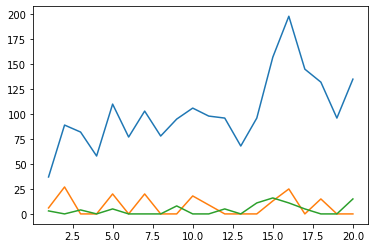

In [67]:
# The input of the model is a sequence of samples (time series) 
# where each sample is represented by three values:
#  - Total revenue
#  - Intensity of campaign 01
#  - Intensity of campaign 02
revenue_series = [37, 89, 82, 58, 110, 77, 103, 78, 95, 106, 98, 96, 68, 96, 157, 198, 145, 132, 96, 135]
campaign_series_01 = [6, 27, 0, 0, 20, 0, 20, 0, 0, 18, 9, 0, 0, 0, 13, 25, 0, 15, 0, 0]
campaign_series_02 = [3, 0, 4, 0, 5, 0, 0, 0, 8, 0, 0, 5, 0, 11, 16, 11, 5, 0, 0, 15]
decay_length = 3
time = range(1, len(revenue_series)+1)
plt.plot(time, revenue_series, time, campaign_series_01, time, campaign_series_02);

In [68]:
#
# Apply time lag (memory effect) to the campaign intensity series
# It is modeled as a convolution operation with exp decay filter (kernel)
#
def lag(x, alpha):
    w = np.array([ np.power(alpha, i) for i in range(decay_length) ])
    xx = np.vstack([ np.append(np.zeros(i), x[:len(x)-i]) for i in range(decay_length) ])
    y = np.dot(w/np.sum(w), xx)
    return y

#
# Apply the lag operation to each campaign/channel 
#
def adstock(x, alpha):
    return np.array([ lag(x[i], alpha[i]) for i in range(len(x)) ]).T

def evaluate_ols_loss(x, y, alpha):
    x_transformed = adstock(x, alpha)
    reg_model = LinearRegression().fit(x_transformed, y)
    return -reg_model.score(x_transformed, y)

#
# Optimize exp decay coefficients jointly with the linear regression model
#
y = np.array(revenue_series)
x = np.vstack([campaign_series_01, campaign_series_02])
solution = minimize(lambda alpha: evaluate_ols_loss(x, y, alpha), x0 = np.zeros(len(x)), tol=1e-6)
print(solution)

      fun: -0.8641145510062492
 hess_inv: array([[ 1.96850137, -0.56199749],
       [-0.56199749,  1.74799283]])
      jac: array([4.32133675e-07, 2.01165676e-07])
  message: 'Optimization terminated successfully.'
     nfev: 40
      nit: 8
     njev: 10
   status: 0
  success: True
        x: array([0.66708352, 0.65271976])


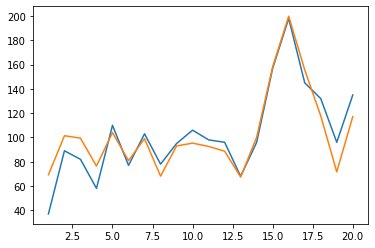

In [69]:
#
# Compare model estimation with the actual revenue series
#
x_transformed = adstock(x, solution['x'])
reg_model = LinearRegression().fit(x_transformed, y)
revenue_predicted = reg_model.predict(x_transformed)
plt.plot(time, revenue_series, time, revenue_predicted);

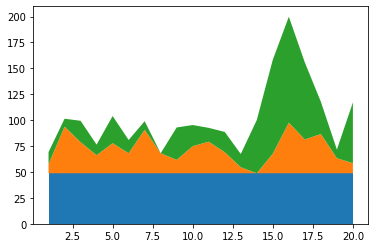

In [70]:
#
# Plot contribution for each channel on top of the intercept
#
plt.stackplot(time, [ 
    [reg_model.intercept_]*len(time), 
    reg_model.coef_[0] * x_transformed[:, 0],
    reg_model.coef_[1] * x_transformed[:, 1]
] );